In [226]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import en_core_web_md
import spacy

from keras.preprocessing.text import Tokenizer
from typing import List
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

from random import randint
from numpy import array, argmax, asarray, zeros
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Embedding

from nltk import word_tokenize
from gensim.models import Word2Vec

from keras.layers.recurrent import SimpleRNN, LSTM
from keras.layers import Flatten, Masking
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

In [15]:
movie = pd.read_csv("Sampled 64k rows.csv", index_col = 0)

In [16]:
movie.head()

,id number,original title,director/creator,movie lenght,review title,review,label,mean of stars,number of reviews,full reviews average stars,category
310028,310028,Cupid,Rob Thomas,1 hour,One of the most charming and fun shows you ne...,A unique take on a contemporary romantic comed...,10,9.54,13,7.8,Comedy
39795,39795,The Lawnmower Man,Brett Leonard,1 hour 48 minutes,does it have to end in evil?,"Technology should be exciting, and upbeating. ...",6,6.06,109,5.4,Horror
181506,181506,The Lost World: Jurassic Park,Steven Spielberg,2 hours 9 minutes,Two Rexes for Part Two,"It's the sequel, so how can we manufacture a w...",7,5.55,245,6.6,Action
43938,43938,Radio Flyer,Richard Donner,1 hour 54 minutes,i love this movie,I love all Joseph Mazello's Movie.. watch also...,10,8.20,50,7.0,Drama
183406,183406,Les Misérables,Bille August,2 hours 14 minutes,"If you can't do something right, don't do it ...",It's not possible to watch this film objective...,2,6.54,143,7.4,Crime


In [17]:
movie.shape

(64149, 11)

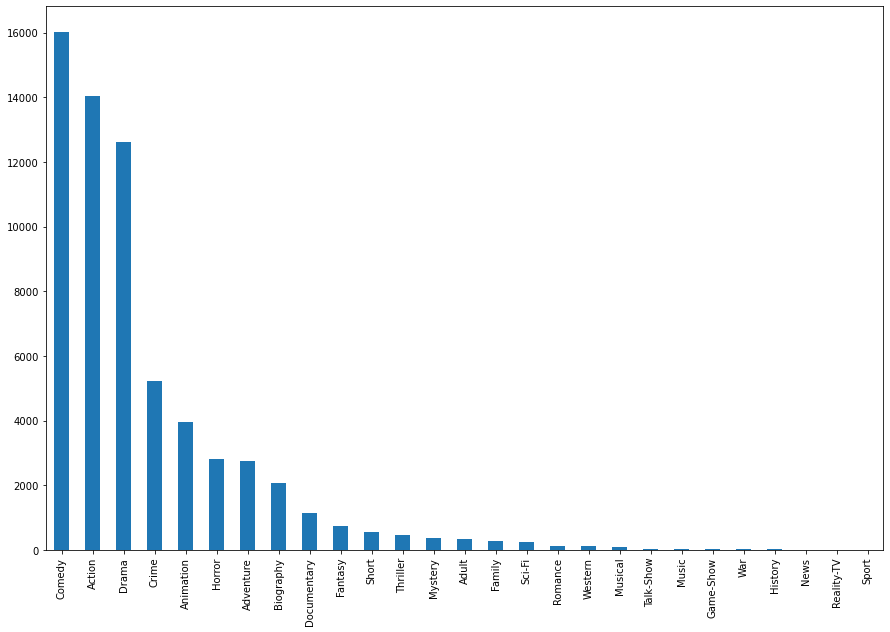

In [18]:
plt.figure(figsize = (15,10))

movie['category'].value_counts().plot(kind = "bar")

In [19]:
movie['category'].unique()

array(['Comedy', 'Horror', 'Action', 'Drama', 'Crime', 'Biography',
       'Adventure', 'Animation', 'Mystery', 'Thriller', 'Fantasy',
       'Sci-Fi', 'Documentary', 'Short', 'Family', 'Adult', 'Talk-Show',
       'Romance', 'Game-Show', 'Musical', 'Western', 'Music', 'History',
       'Reality-TV', 'News', 'War', 'Sport'], dtype=object)

In [22]:
movie['category'] = movie['category'].str.replace(r'Horror|Biography|Adventure|Mystery|Thriller|Fantasy|Sci-Fi|Documentary|\
                                                    Documentary|Short|Family|Adult|Talk-Show|Romance|Game-Show|\
                                                    Musical|Western|Music|History|Reality-TV|News|War|Sport|Othersal', "Others")


<ipython-input-22-c252fb4e4119>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  movie['category'] = movie['category'].str.replace(r'Horror|Biography|Adventure|Mystery|Thriller|Fantasy|Sci-Fi|Documentary|\


In [23]:
movie['category'].unique()

array(['Comedy', 'Others', 'Action', 'Drama', 'Crime', 'Animation'],
      dtype=object)

In [230]:
cat_df = pd.DataFrame(movie['category'].value_counts().reset_index()).rename(columns={"index":"category", "category":"No. of records"})
cat_df

,category,No. of records
0,Comedy,16006
1,Action,14051
2,Drama,12624
3,Others,12288
4,Crime,5236
5,Animation,3944


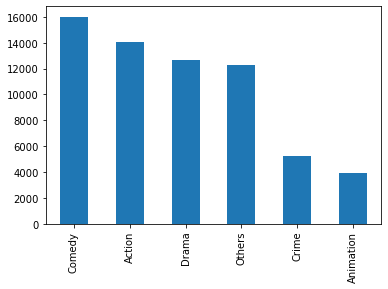

In [206]:
movie['category'].value_counts().plot(kind = "bar")

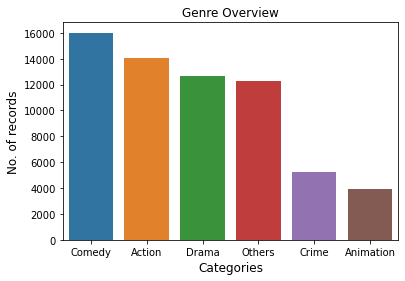

In [239]:
sns.barplot(data = cat_df, x="category", y = "No. of records")
plt.ylabel("No. of records", size=12)
plt.xlabel("Categories", size=12)
plt.title("Genre Overview")

plt.savefig("Genra Overview.png", bbox_inches = "tight")

In [241]:
movie.groupby("category")['label'].mean()

category
Action       6.113800
Animation    7.004564
Comedy       6.757966
Crime        6.607716
Drama        6.868821
Others       6.458822
Name: label, dtype: float64

## Word Count

In [24]:
import re
import nltk
import spacy

nlp = spacy.load('en_core_web_md',disable=['ner', 'parser'])

In [25]:
# define remove stopword function
def remove_stopwords(PandaSeries, stopword_list):
    review_list = []
    for review in PandaSeries:
        review = re.sub(r'(\"|\;|\\|\.|\,|\\|\`|\/|\#|\&|\(|\)|\n|\:|\-|\d|\<br \>|\$|\_|\>|\<|\bbr\b)', '', review)
        word_list = nltk.word_tokenize(review)
        new_word_list = []
        for word in word_list:
            if word.lower() not in set(stopword_list):
                new_word_list.append(word.lower())
        stopword_free = " ".join(new_word_list)
        
        review_list.append(stopword_free)
    return review_list

In [26]:
from nltk.corpus import stopwords
stopdict = stopwords.words('english')

In [28]:
reviews_cleaned = remove_stopwords(movie['review'], stopdict)

In [39]:
reviews_cleaned = [re.sub('[^\w\s]','',x) for x in reviews_cleaned]
    

In [40]:
from tqdm import tqdm
# word list
new_word_list = []

for review in tqdm(reviews_cleaned):
    word_list = nltk.word_tokenize(review)
    for word in word_list:
        new_word_list.append(word)

100%|██████████| 64149/64149 [00:35<00:00, 1819.57it/s]


In [41]:
from collections import Counter

movie_counter = Counter(new_word_list)
movie_counter.most_common(100)

[('s', 157621),
 ('movie', 99787),
 ('film', 90228),
 ('nt', 75964),
 ('one', 61755),
 ('like', 46562),
 ('good', 40152),
 ('story', 29547),
 ('really', 28400),
 ('would', 28350),
 ('time', 27681),
 ('great', 26324),
 ('even', 26119),
 ('well', 25263),
 ('also', 25065),
 ('much', 24499),
 ('see', 24099),
 ('first', 21041),
 ('get', 20947),
 ('people', 19773),
 ('could', 19653),
 ('character', 19082),
 ('characters', 18887),
 ('way', 18300),
 ('movies', 17705),
 ('best', 17420),
 ('love', 17269),
 ('made', 17179),
 ('make', 17050),
 ('bad', 17002),
 ('two', 16812),
 ('watch', 16430),
 ('many', 16397),
 ('think', 16191),
 ('life', 15550),
 ('little', 15263),
 ('films', 15199),
 ('never', 14835),
 ('still', 14744),
 ('plot', 14096),
 ('better', 13784),
 ('know', 13712),
 ('seen', 13373),
 ('show', 13279),
 ('action', 13009),
 ('man', 12971),
 ('acting', 12754),
 ('scenes', 12646),
 ('end', 12595),
 ('say', 11715),
 ('back', 11561),
 ('scene', 11536),
 ('ever', 11448),
 ('lot', 11232),
 ('

In [42]:
word_df = pd.DataFrame.from_dict(movie_counter, orient='index').reset_index()

In [43]:
word_df = word_df.rename(columns = {"index":"word",0:"count"}).sort_values(by = "count", ascending = False)

In [44]:
word_df.head()

,word,count
44,s,157621
42,movie,99787
237,film,90228
61,nt,75964
29,one,61755


In [45]:
len(word_df)

229230

## Preprocessing

### Reviews

In [89]:
nlp = en_core_web_md.load(disable=['ner', 'parser'])

In [46]:
reviews = movie['review']

In [47]:
stopwords_removed_reviews = list(
    map(lambda review: " ".join([token.text for token in nlp(review) if not token.is_stop]), reviews))

In [48]:
## Tokenize reviews
tokenizer = Tokenizer(num_words=5000, oov_token="UNKNOWN_TOKEN")
tokenizer.fit_on_texts(stopwords_removed_reviews)

In [49]:
def integer_encode_documents(docs: List[str], tokenizer: Tokenizer)-> List[List[int]]:
    documents = []
    for d in docs:
        doc_integers = []
        for i in text_to_word_sequence(d):
            doc_integers.append(tokenizer.word_index[i])
        documents.append(doc_integers)
    return documents

# integer encode the documents
encoded_reviews = integer_encode_documents(stopwords_removed_reviews, tokenizer)

In [51]:
def get_max_token_length_per_doc(docs: List[List[str]])-> int:
    return max(list(map(lambda doc: len(doc), tokenizer.texts_to_sequences(docs))))

MAX_SEQUENCE_LENGTH = get_max_token_length_per_doc(stopwords_removed_reviews)

In [52]:
MAX_SEQUENCE_LENGTH

1460

Though the max length is 1460, most of the reviews would not be so long, hence we examine what is the 99% percentile of the review length, and we will use that as our max_length.

In [53]:
lengths = list(map(lambda doc: len(doc), tokenizer.texts_to_sequences(stopwords_removed_reviews)))

(array([5.1637e+04, 9.6680e+03, 2.2310e+03, 5.5800e+02, 4.0000e+01,
        1.4000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([1.0000e+00, 1.4690e+02, 2.9280e+02, 4.3870e+02, 5.8460e+02,
        7.3050e+02, 8.7640e+02, 1.0223e+03, 1.1682e+03, 1.3141e+03,
        1.4600e+03]),
 <a list of 10 Patch objects>)

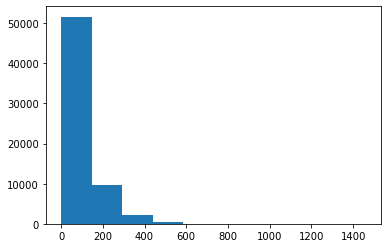

In [54]:
plt.hist(lengths)

In [55]:
np.quantile(lengths, 0.99)

436.0

In [76]:
MAX_SEQUENCE_LENGTH = 450

In [77]:
padded_reviews = pad_sequences(encoded_reviews, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

In [60]:
# padded_reviews[0:2]

### Review titles

In [61]:
titles = movie['review title']

In [62]:
stopwords_removed_titles = list(
    map(lambda title: " ".join([token.text for token in nlp(title) if not token.is_stop]), titles))

In [63]:
## Tokenize reviews
tokenizer.fit_on_texts(stopwords_removed_titles)

In [64]:
encoded_titles = integer_encode_documents(stopwords_removed_titles, tokenizer)

In [65]:
MAX_SEQUENCE_LENGTH_title = get_max_token_length_per_doc(stopwords_removed_titles)
MAX_SEQUENCE_LENGTH_title

113

In [66]:
padded_titles = pad_sequences(encoded_titles, maxlen=MAX_SEQUENCE_LENGTH_title, padding='post')

### Movie title

In [67]:
originals = movie['original title']

In [68]:
stopwords_removed_originals = list(
    map(lambda original: " ".join([token.text for token in nlp(original) if not token.is_stop]), originals))

In [69]:
## Tokenize reviews
tokenizer.fit_on_texts(stopwords_removed_originals)

In [70]:
encoded_originals = integer_encode_documents(stopwords_removed_originals, tokenizer)

In [71]:
MAX_SEQUENCE_LENGTH_original = get_max_token_length_per_doc(stopwords_removed_originals)
MAX_SEQUENCE_LENGTH_original

17

In [72]:
padded_originals = pad_sequences(encoded_originals, maxlen=MAX_SEQUENCE_LENGTH_title, padding='post')

### Concat the 3 columns

We would like to include all these three columns' information as the model input, so we concat all three padded docs together.

In [78]:
# concat padded docs from all three columns
padded_doc = np.concatenate((padded_reviews, padded_titles,padded_originals), axis = 1)

In [79]:
padded_doc.shape

(64149, 676)

In [80]:
MAX_SEQUENCE_LENGTH_combined = padded_doc.shape[1]
MAX_SEQUENCE_LENGTH_combined

676

In [81]:
encoder = LabelEncoder()
labels = to_categorical(encoder.fit_transform(movie['category']))

In [82]:
labels[0:5]

array([[0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0.]], dtype=float32)

In [191]:
indices = range(0,len(padded_doc))

In [192]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, train_index, test_index = train_test_split(padded_doc, labels, indices, test_size=0.25, random_state = 42)

## Embedding

In [87]:
VOCAB_SIZE = int(len(tokenizer.word_index) * 1.1)

In [88]:
VOCAB_SIZE

136250

In [64]:
# def load_glove_vectors():
#     embeddings_index = {}
#     with open('glove.6B.100d.txt') as f:
#         for line in f:
#             values = line.split()
#             word = values[0]
#             coefs = asarray(values[1:], dtype='float32')
#             embeddings_index[word] = coefs
#     print('Loaded %s word vectors.' % len(embeddings_index))
#     return embeddings_index


# embeddings_index = load_glove_vectors()

Loaded 400000 word vectors.


In [65]:
# # create a weight matrix for words in training docs
# embedding_matrix = zeros((VOCAB_SIZE, 100))
# for word, i in tokenizer.word_index.items():
#     embedding_vector = embeddings_index.get(word)
#     if embedding_vector is not None: # check that it is an actual word that we have embeddings for
#         embedding_matrix[i] = embedding_vector

We tried to use the pre-trained word embeddings, but the performance is not satisfying, hence we use the review column to train our own word embedding which would help improve the model performance.

In [76]:
# Self train the word embedding using the review column
docs = [word_tokenize(review) for review in reviews]
model = Word2Vec(docs, vector_size=300, window=10, min_count=1, workers=4)
model.wv.save_word2vec_format('movie_embeddings.txt', binary=False)

In [181]:
def load_glove_vectors():
    embeddings_index = {}
    with open('movie_embeddings.txt') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print('Loaded %s word vectors.' % len(embeddings_index))
    return embeddings_index
embeddings_index = load_glove_vectors()

embedding_matrix_movie = zeros((VOCAB_SIZE, 300))
for word, i in tokenizer.word_index.items():
    if i == VOCAB_SIZE:
        break
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: # check that it is an actual word that we have embeddings for
        embedding_matrix_movie[i] = embedding_vector

Loaded 261388 word vectors.


## Model

In [90]:
# define model

def make_lstm_classification_model(plot=False):
    model = Sequential()
    model.add(Embedding(VOCAB_SIZE, 300, weights=[embedding_matrix_movie], input_length=MAX_SEQUENCE_LENGTH_combined, trainable=True))
    model.add(Masking(mask_value=0.0)) # masking layer, masks any words that don't have an embedding as 0s.
    model.add(LSTM(units=32, input_shape=(1, MAX_SEQUENCE_LENGTH_combined)))
    model.add(Dense(16))
    model.add(Dense(6, activation='softmax'))
    
    # Compile the model
    model.compile(
    optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    # summarize the model
    model.summary()
    
    if plot:
        plot_model(model, to_file='model.png', show_shapes=True)
    return model

def make_multi_classification_rnn_model(plot=False):
    model = Sequential()
    model.add(Embedding(VOCAB_SIZE, 300, weights=[embedding_matrix_movie], input_length=MAX_SEQUENCE_LENGTH_combined, trainable=True))
    model.add(Masking(mask_value=0.0)) # masking layer, masks any words that don't have an embedding as 0s.
    model.add(SimpleRNN(units=64, input_shape=(1, MAX_SEQUENCE_LENGTH_combined)))
    model.add(Dense(16))
    model.add(Dense(6, activation='softmax'))
    
    # Compile the model
    model.compile(
    optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    # summarize the model
    model.summary()
    
    if plot:
        plot_model(model, to_file='model.png', show_shapes=True)
    return model

### LMST

#### pre_trained word_embedding

In [264]:
def load_glove_vectors():
    embeddings_index = {}
    with open('glove.6B.100d.txt') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print('Loaded %s word vectors.' % len(embeddings_index))
    return embeddings_index


embeddings_index = load_glove_vectors()

Loaded 400000 word vectors.


In [265]:
# create a weight matrix for words in training docs
embedding_matrix = zeros((VOCAB_SIZE, 100))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: # check that it is an actual word that we have embeddings for
        embedding_matrix[i] = embedding_vector

In [268]:
def make_lstm_classification_model(plot=False):
    model = Sequential()
    model.add(Embedding(VOCAB_SIZE, 100, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH_combined, trainable=False))
    model.add(Masking(mask_value=0.0)) # masking layer, masks any words that don't have an embedding as 0s.
    model.add(LSTM(units=32, input_shape=(1, MAX_SEQUENCE_LENGTH_combined)))
    model.add(Dense(16))
    model.add(Dense(6, activation='softmax'))
    
    # Compile the model
    model.compile(
    optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    # summarize the model
    model.summary()
    
    if plot:
        plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [272]:
model = make_lstm_classification_model()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 410, 100)          13625000  
_________________________________________________________________
masking_14 (Masking)         (None, 410, 100)          0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 32)                17024     
_________________________________________________________________
dense_28 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_29 (Dense)             (None, 6)                 102       
Total params: 13,642,654
Trainable params: 17,654
Non-trainable params: 13,625,000
_________________________________________________________________


In [274]:
history = model.fit(X_train, y_train,validation_split = 0.1, epochs=5, verbose=1)

Epoch 1/5
1354/1354 [==============================] - 189s 140ms/step - loss: 1.5474 - accuracy: 0.3680 - val_loss: 1.4140 - val_accuracy: 0.4524
Epoch 2/5
1354/1354 [==============================] - 183s 135ms/step - loss: 1.2733 - accuracy: 0.5177 - val_loss: 1.1982 - val_accuracy: 0.5569
Epoch 3/5
1354/1354 [==============================] - 181s 134ms/step - loss: 1.0679 - accuracy: 0.6188 - val_loss: 1.0524 - val_accuracy: 0.6303
Epoch 4/5
1354/1354 [==============================] - 181s 133ms/step - loss: 0.9325 - accuracy: 0.6771 - val_loss: 0.9925 - val_accuracy: 0.6569
Epoch 5/5
1354/1354 [==============================] - 184s 136ms/step - loss: 0.8419 - accuracy: 0.7142 - val_loss: 0.9266 - val_accuracy: 0.6854


In [275]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print('Accuracy: %f' % (accuracy*100))

502/502 [==============================] - 12s 23ms/step - loss: 0.9611 - accuracy: 0.6820
Accuracy: 68.200523


#### Self_trained

In [156]:
model = make_lstm_classification_model()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 676, 300)          39508500  
_________________________________________________________________
masking_5 (Masking)          (None, 676, 300)          0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 32)                42624     
_________________________________________________________________
dense_13 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_14 (Dense)             (None, 6)                 102       
Total params: 39,551,754
Trainable params: 39,551,754
Non-trainable params: 0
_________________________________________________________________


In [157]:
# fit the model
history = model.fit(X_train, y_train,validation_split = 0.1, epochs=5, verbose=1)

Epoch 1/5
1354/1354 [==============================] - 1023s 752ms/step - loss: 1.3819 - accuracy: 0.4467 - val_loss: 0.7239 - val_accuracy: 0.7485
Epoch 2/5
1354/1354 [==============================] - 974s 719ms/step - loss: 0.5511 - accuracy: 0.8111 - val_loss: 0.6571 - val_accuracy: 0.7747
Epoch 3/5
1354/1354 [==============================] - 1170s 864ms/step - loss: 0.3349 - accuracy: 0.8902 - val_loss: 0.6816 - val_accuracy: 0.7835
Epoch 4/5
1354/1354 [==============================] - 5236s 4s/step - loss: 0.2074 - accuracy: 0.9325 - val_loss: 0.7977 - val_accuracy: 0.7839
Epoch 5/5
1354/1354 [==============================] - 948s 700ms/step - loss: 0.1219 - accuracy: 0.9627 - val_loss: 0.9432 - val_accuracy: 0.7783


In [158]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print('Accuracy: %f' % (accuracy*100))

502/502 [==============================] - 42s 83ms/step - loss: 0.9424 - accuracy: 0.7770
Accuracy: 77.696723


The training accuracy is higher than the trsting accuracy by nearly 20%, so there is an overfitting issue. To avoid that, we only fit the training data with 3 epochs in later on models.

In [159]:
predictions = np.argmax(model.predict(X_test), axis=-1)
y_test_num = [i.tolist().index(1) for i in y_test]

In [160]:
confusion_matrix(y_test_num, predictions)

array([[2898,   37,  187,   79,   99,  168],
       [  30,  830,   43,    3,   13,   55],
       [ 117,   42, 3249,   82,  283,  241],
       [  83,    5,   87,  965,  128,  101],
       [ 104,   14,  253,  114, 2375,  312],
       [ 187,   48,  281,   88,  293, 2144]])

#### Parameter Tuning - change max length

In the previous model, we used 99% percentile of review length to set our max_length parameter. There might be quite a number of 0 in the padded doc for those short reviews. Hence, we tried to decrease this max_length by using 95% of the review length instead.

In [194]:
np.quantile(lengths, 0.95)

281.0

In [195]:
padded_reviews = pad_sequences(encoded_reviews, maxlen=280, padding='post')

In [196]:
# concat padded docs from all three columns
padded_doc = np.concatenate((padded_reviews, padded_titles,padded_originals), axis = 1)

In [197]:
X_train, X_test, y_train, y_test, train_index, test_index = train_test_split(padded_doc, labels, indices, test_size=0.25, random_state = 42)

In [198]:
MAX_SEQUENCE_LENGTH_combined = padded_doc.shape[1]
MAX_SEQUENCE_LENGTH_combined

410

In [199]:
VOCAB_SIZE = 136250
def make_lstm_classification_model(plot=False):
    model = Sequential()
    model.add(Embedding(VOCAB_SIZE, 300, weights=[embedding_matrix_movie], input_length=MAX_SEQUENCE_LENGTH_combined, trainable=True))
    model.add(Masking(mask_value=0.0)) # masking layer, masks any words that don't have an embedding as 0s.
    model.add(LSTM(units=32, input_shape=(1, MAX_SEQUENCE_LENGTH_combined)))
    model.add(Dense(16))
    model.add(Dense(6, activation='softmax'))
    
    # Compile the model
    model.compile(
    optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    # summarize the model
    model.summary()
    
    if plot:
        plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [200]:
model = make_lstm_classification_model()
history = model.fit(X_train, y_train,validation_split = 0.1, epochs=3, verbose=1)

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 410, 300)          40875000  
_________________________________________________________________
masking_11 (Masking)         (None, 410, 300)          0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 32)                42624     
_________________________________________________________________
dense_22 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_23 (Dense)             (None, 6)                 102       
Total params: 40,918,254
Trainable params: 40,918,254
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
1354/1354 [==============================] - 770s 561ms/step - loss: 1.3796 - accuracy: 0.4520 - 

In [201]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print('Accuracy: %f' % (accuracy*100))

502/502 [==============================] - 37s 74ms/step - loss: 0.6458 - accuracy: 0.8258
Accuracy: 82.578874


In [202]:
predictions = np.argmax(model.predict(X_test), axis=-1)
y_test_num = [i.tolist().index(1) for i in y_test]

In [203]:
confusion_matrix(y_test_num, predictions)

array([[3126,   13,  112,   55,  130,   73],
       [  42,  806,   51,    5,   28,   52],
       [ 141,   29, 3375,   54,  234,  145],
       [  71,    2,   55, 1056,  112,   47],
       [ 155,    6,  201,   56, 2568,  165],
       [ 173,   38,  194,   71,  284, 2313]])

In [205]:
print(classification_report(y_test_num, predictions))

              precision    recall  f1-score   support

           0       0.84      0.89      0.87      3509
           1       0.90      0.82      0.86       984
           2       0.85      0.85      0.85      3978
           3       0.81      0.79      0.80      1343
           4       0.77      0.81      0.79      3151
           5       0.83      0.75      0.79      3073

    accuracy                           0.83     16038
   macro avg       0.83      0.82      0.82     16038
weighted avg       0.83      0.83      0.83     16038



In [221]:
roc_auc_score(to_categorical(encoder.fit_transform(y_test_num)), 
              to_categorical(encoder.fit_transform(predictions)), multi_class="ovr", average="weighted")

0.8910744579975285

#### Some examples

Since this model has a higher accuracy, we select this as our deep learning model and look at some of the predictions in detail.

In [251]:
df_test = movie.iloc[test_index,:]
df_test['y_label'] = y_test_num
df_test['Prediction'] = predictions

df_test

<ipython-input-251-853987565cd0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['y_label'] = y_test_num
<ipython-input-251-853987565cd0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['Prediction'] = predictions


,id number,original title,director/creator,movie lenght,review title,review,label,mean of stars,number of reviews,full reviews average stars,category,y_label,Prediction
256169,256169,High Art,Lisa Cholodenko,1 hour 41 minutes,Where's the Passion?,The acting was good and I didn't mind the slow...,4,7.87,75,6.6,Drama,4,4
180966,180966,A Life Less Ordinary,Danny Boyle,1 hour 43 minutes,McGregor and Diaz are real stars here,"I'm a big fan of Cameron Diaz, and Ewan McGreg...",8,6.99,126,6.4,Comedy,2,2
59122,59122,Groundhog Day,Harold Ramis,1 hour 41 minutes,It was somewhat confusing...,"Groundhog Day, it's a movie we watched in film...",3,7.20,147,8.0,Comedy,2,2
115708,115708,Kids,Larry Clark,1 hour 31 minutes,Its real!,In denial of what your kids are doing? Watch t...,8,5.99,199,7.1,Drama,4,4
90487,90487,Octobre,Pierre Falardeau,1 hour 37 minutes,You need to take a distance to appreciate thi...,"In regards to previous comments, a few things ...",9,6.70,10,7.3,Drama,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
312273,312273,The '60s,Josh Hamilton,2 hours 52 minutes,I can't believe I watched this movie - it SUC...,"Somehow they summed up the 60's, ten years tha...",1,6.97,29,7.0,Drama,4,4
244520,244520,SLC Punk!,James Merendino,1 hour 37 minutes,"A hilarious indie film, well worth watching.","First, a disclaimer. SLC Punk! isn't for ever...",9,7.50,113,7.4,Comedy,2,2
241787,241787,La fée Carabosse ou le poignard fatal,Georges Méliès,12 minutes,Colorful and Confusing,This is another example of a story that has sc...,7,7.33,3,6.3,Others,5,3
165326,165326,Bliss,Lance Young,1 hour 43 minutes,Definitely different...,"I don't think this is a great movie, but I do ...",6,7.78,27,6.0,Drama,4,4


In [258]:
incorrect1 = df_test[df_test['y_label'] != df_test['Prediction']].head(1)
incorrect1

,id number,original title,director/creator,movie lenght,review title,review,label,mean of stars,number of reviews,full reviews average stars,category,y_label,Prediction
151398,151398,Reggie's Prayer,Paul McKellips,1 hour 34 minutes,A Must Watch,A player-turned-coach story with the main char...,9,7.57,7,4.8,Drama,4,0


In [262]:
pd.set_option("display.max_colwidth", -1)
incorrect1['review']

<ipython-input-262-9af4d5874abf>:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option("display.max_colwidth", -1)


151398    A player-turned-coach story with the main character being played by a retired football player gives this film an authentic edge that makes the story line come to life. It's a must-watch for any football fan.
Name: review, dtype: object

In [281]:
correct1 = df_test[df_test['y_label'] == df_test['Prediction']].head(2)
correct1

,id number,original title,director/creator,movie lenght,review title,review,label,mean of stars,number of reviews,full reviews average stars,category,y_label,Prediction
256169,256169,High Art,Lisa Cholodenko,1 hour 41 minutes,Where's the Passion?,"The acting was good and I didn't mind the slow build up, but the film was very hard to relate to as it was very dark, missing all happiness. Lots and lots and lots of drugs. I think the part that turned me off the most was when they finally got together, instead of soft passionate love it felt hard and cold. The sex scene was weird and almost made me feel uncomfortable which is not normal for me. I think it was missing that slow softness that most lesbian films have. Or even the lustful eyes or something- it just didn't feel right. And then to make it worse the ending was a real downer. Instead of a fun or enjoyable love story, it felt like the writer/directer was trying to bring out a much deeper meaning to the film. This movie is about brining awareness to the very real struggles people have in their lives and where that road can lead you.",4,7.87,75,6.6,Drama,4,4
180966,180966,A Life Less Ordinary,Danny Boyle,1 hour 43 minutes,McGregor and Diaz are real stars here,"I'm a big fan of Cameron Diaz, and Ewan McGregor caught my attention after his riveting performance in Trainspotting. McGregor is the bumbling kidnapper and Diaz is the victim who seems to know more about kidnapping than he does. All this makes for a really funny comic act from the duo as they progress from kidnapper/victim to lovers, with the help of some angels who live in a seemingly hip heaven. The pace of the movie doesn't let up much, and you find yourself immersed totally as you wait for the ending, which, sadly, could have more of a cliffhanger effect than it has now.",8,6.99,126,6.4,Comedy,2,2


### RNN

#### pre_trained

In [276]:
def make_multi_classification_rnn_model(plot=False):
    model = Sequential()
    model.add(Embedding(VOCAB_SIZE, 100, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH_combined, trainable=False))
    model.add(Masking(mask_value=0.0)) # masking layer, masks any words that don't have an embedding as 0s.
    model.add(SimpleRNN(units=64, input_shape=(1, MAX_SEQUENCE_LENGTH_combined)))
    model.add(Dense(16))
    model.add(Dense(6, activation='softmax'))
    
    # Compile the model
    model.compile(
    optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    # summarize the model
    model.summary()
    
    if plot:
        plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [277]:
model_RNN = make_multi_classification_rnn_model()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, 410, 100)          13625000  
_________________________________________________________________
masking_15 (Masking)         (None, 410, 100)          0         
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 64)                10560     
_________________________________________________________________
dense_30 (Dense)             (None, 16)                1040      
_________________________________________________________________
dense_31 (Dense)             (None, 6)                 102       
Total params: 13,636,702
Trainable params: 11,702
Non-trainable params: 13,625,000
_________________________________________________________________


In [278]:
# fit the model
history_RNN = model_RNN.fit(X_train, y_train,validation_split = 0.1, epochs=5, verbose=1)

Epoch 1/5
1354/1354 [==============================] - 116s 85ms/step - loss: 1.6715 - accuracy: 0.3050 - val_loss: 1.4645 - val_accuracy: 0.4100
Epoch 2/5
1354/1354 [==============================] - 113s 84ms/step - loss: 1.4184 - accuracy: 0.4499 - val_loss: 1.3308 - val_accuracy: 0.4994
Epoch 3/5
1354/1354 [==============================] - 113s 84ms/step - loss: 1.2701 - accuracy: 0.5256 - val_loss: 1.2579 - val_accuracy: 0.5384
Epoch 4/5
1354/1354 [==============================] - 115s 85ms/step - loss: 1.1564 - accuracy: 0.5797 - val_loss: 1.1819 - val_accuracy: 0.5713
Epoch 5/5
1354/1354 [==============================] - 114s 84ms/step - loss: 1.0762 - accuracy: 0.6176 - val_loss: 1.1383 - val_accuracy: 0.5950


In [279]:
loss, accuracy = model_RNN.evaluate(X_test, y_test, verbose=1)
print('Accuracy: %f' % (accuracy*100))

502/502 [==============================] - 10s 20ms/step - loss: 1.1403 - accuracy: 0.5960
Accuracy: 59.602195


#### Self_trained

In [110]:
def make_multi_classification_rnn_model(plot=False):
    model = Sequential()
    model.add(Embedding(VOCAB_SIZE, 300, weights=[embedding_matrix_movie], input_length=MAX_SEQUENCE_LENGTH_combined, trainable=True))
    model.add(Masking(mask_value=0.0)) # masking layer, masks any words that don't have an embedding as 0s.
    model.add(SimpleRNN(units=64, input_shape=(1, MAX_SEQUENCE_LENGTH_combined)))
    model.add(Dense(16))
    model.add(Dense(6, activation='softmax'))
    
    # Compile the model
    model.compile(
    optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    # summarize the model
    model.summary()
    
    if plot:
        plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [111]:
model_RNN = make_multi_classification_rnn_model()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 506, 300)          40875000  
_________________________________________________________________
masking_2 (Masking)          (None, 506, 300)          0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 64)                23360     
_________________________________________________________________
dense_4 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 102       
Total params: 40,899,502
Trainable params: 40,899,502
Non-trainable params: 0
_________________________________________________________________


In [112]:
# fit the model
history_RNN = model_RNN.fit(X_train, y_train,validation_split = 0.1, epochs=5, verbose=1)

Epoch 1/5
1354/1354 [==============================] - 756s 557ms/step - loss: 1.4828 - accuracy: 0.4363 - val_loss: 0.9621 - val_accuracy: 0.6660
Epoch 2/5
1354/1354 [==============================] - 765s 565ms/step - loss: 0.7838 - accuracy: 0.7289 - val_loss: 0.8535 - val_accuracy: 0.7099
Epoch 3/5
1354/1354 [==============================] - 743s 549ms/step - loss: 0.5717 - accuracy: 0.8016 - val_loss: 0.8693 - val_accuracy: 0.7205
Epoch 4/5
1354/1354 [==============================] - 744s 549ms/step - loss: 0.4496 - accuracy: 0.8440 - val_loss: 0.9303 - val_accuracy: 0.7240
Epoch 5/5
1354/1354 [==============================] - 742s 548ms/step - loss: 0.3553 - accuracy: 0.8775 - val_loss: 1.0004 - val_accuracy: 0.7244


In [113]:
loss, accuracy = model_RNN.evaluate(X_test, y_test, verbose=1)
print('Accuracy: %f' % (accuracy*100))

502/502 [==============================] - 30s 59ms/step - loss: 1.0221 - accuracy: 0.7182
Accuracy: 71.816933


#### Changing max length

Same to the LSTM model, we now try to decrease the max_length and use 3 epochs.

In [242]:
MAX_SEQUENCE_LENGTH_combined = 410

In [243]:
VOCAB_SIZE = 136250

In [209]:
def make_multi_classification_rnn_model(plot=False):
    model = Sequential()
    model.add(Embedding(VOCAB_SIZE, 300, weights=[embedding_matrix_movie], input_length=MAX_SEQUENCE_LENGTH_combined, trainable=True))
    model.add(Masking(mask_value=0.0)) # masking layer, masks any words that don't have an embedding as 0s.
    model.add(SimpleRNN(units=64, input_shape=(1, MAX_SEQUENCE_LENGTH_combined)))
    model.add(Dense(16))
    model.add(Dense(6, activation='softmax'))
    
    # Compile the model
    model.compile(
    optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    # summarize the model
    model.summary()
    
    if plot:
        plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [210]:
model = make_multi_classification_rnn_model()
history = model.fit(X_train, y_train,validation_split = 0.1, epochs=3, verbose=1)

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 410, 300)          40875000  
_________________________________________________________________
masking_12 (Masking)         (None, 410, 300)          0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 64)                23360     
_________________________________________________________________
dense_24 (Dense)             (None, 16)                1040      
_________________________________________________________________
dense_25 (Dense)             (None, 6)                 102       
Total params: 40,899,502
Trainable params: 40,899,502
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
1354/1354 [==============================] - 1031s 759ms/step - loss: 1.4389 - accuracy: 0.4470 -

In [211]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print('Accuracy: %f' % (accuracy*100))

502/502 [==============================] - 32s 63ms/step - loss: 0.6414 - accuracy: 0.8214
Accuracy: 82.142413


In [212]:
predictions_RNN = np.argmax(model.predict(X_test), axis=-1)
y_test_num = [i.tolist().index(1) for i in y_test]

In [213]:
confusion_matrix(y_test_num, predictions_RNN)

array([[3079,   41,  123,   40,  119,  107],
       [  38,  748,   57,   24,   50,   67],
       [ 117,   46, 3409,   57,  183,  166],
       [  56,   19,   59, 1072,   86,   51],
       [ 142,   33,  240,   57, 2506,  173],
       [ 158,   49,  239,   60,  207, 2360]])

In [214]:
print(classification_report(y_test_num, predictions_RNN))

              precision    recall  f1-score   support

           0       0.86      0.88      0.87      3509
           1       0.80      0.76      0.78       984
           2       0.83      0.86      0.84      3978
           3       0.82      0.80      0.81      1343
           4       0.80      0.80      0.80      3151
           5       0.81      0.77      0.79      3073

    accuracy                           0.82     16038
   macro avg       0.82      0.81      0.81     16038
weighted avg       0.82      0.82      0.82     16038



In [222]:
roc_auc_score(to_categorical(encoder.fit_transform(y_test_num)), 
              to_categorical(encoder.fit_transform(predictions_RNN)), multi_class="ovr", average="weighted")

0.8887212164696237